### Some imports

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

2024-05-19 11:37:22.723626: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-19 11:37:22.755025: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 11:37:23.273727: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tesla_df = pd.read_csv("./docs/Homework3 - TSLA.csv")
tesla_df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

# PART I

## Data Preperation

In [3]:
tesla_data = tesla_df
tesla_data['Date'] = pd.to_datetime(tesla_data['Date'])
tesla_data.set_index('Date', inplace=True)

tesla_data.sort_index(inplace=True)
tesla_data = tesla_data[:2950]
data = tesla_data[['Close']].values  # Use 'Close' price for prediction

scaler = MinMaxScaler(feature_range=(0, 1))  # Normalize
scaled_data = scaler.fit_transform(data)

train_size = int(len(scaled_data) * 0.7)  # (70% train, 30% test)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]


def create_sequences(data, seq_length):  # Create sequences for LSTM
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)


seq_length = 60
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  # Reshape data to fit LSTM input
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("Shape of training set: {}".format(X_train.shape))
print("Shape of test set: {}".format(X_test.shape))

Shape of training set: (2005, 60, 1)
Shape of test set: (825, 60, 1)


### The Model

In [4]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.4456e-04 - val_loss: 0.0039
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 5.6236e-06 - val_loss: 0.0038
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 5.3219e-06 - val_loss: 0.0026
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 5.1288e-06 - val_loss: 0.0028
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 4.9995e-06 - val_loss: 0.0026
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 5.6253e-06 - val_loss: 0.0025
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 4.3047e-06 - val_loss: 0.0022
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 4.3979e-06 - val_loss: 0.0019
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 3.0256e-06 - val_loss: 0.0015
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 4.5587e-06 - val_loss: 0.0026


### Predictions

In [5]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_test_inv, predictions))
print(f'RMSE: {rmse}')

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 62.432317390200005


### Plot the results

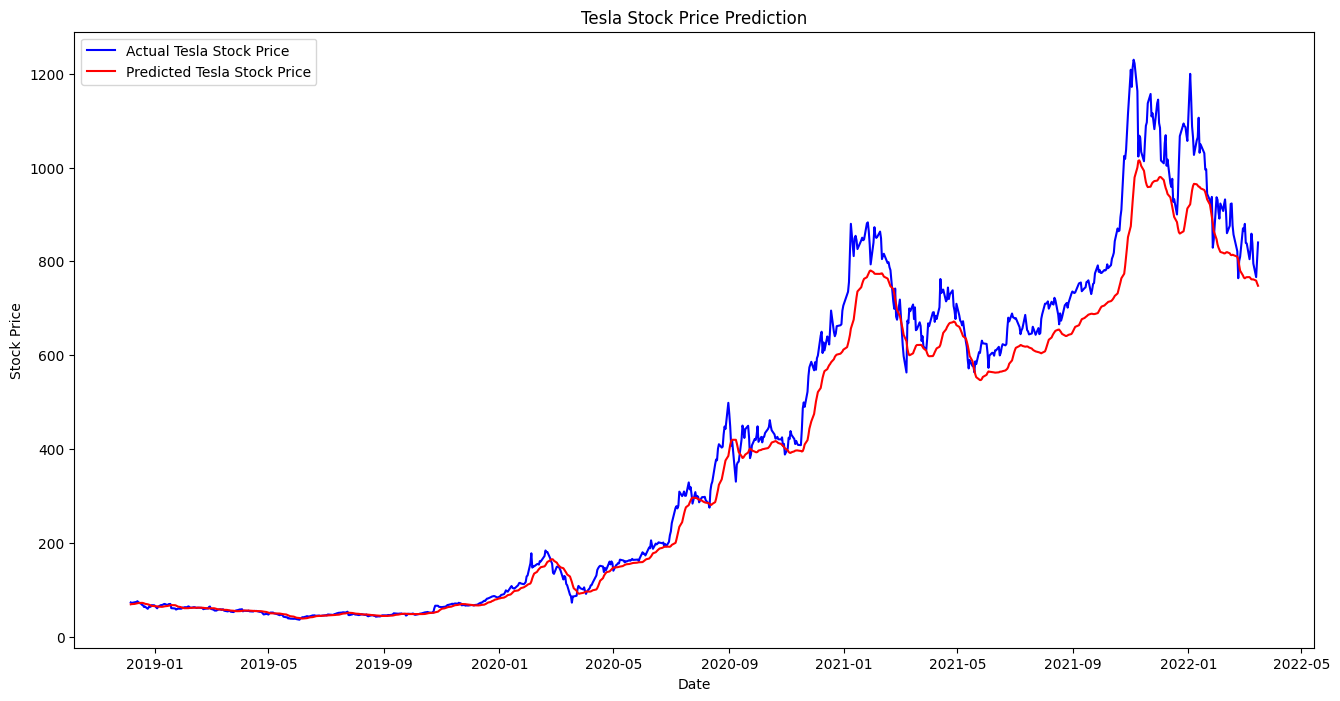

In [6]:
plt.figure(figsize=(16, 8))
plt.plot(tesla_data.index[train_size + seq_length:], y_test_inv, color='blue', label='Actual Tesla Stock Price')
plt.plot(tesla_data.index[train_size + seq_length:], predictions, color='red', label='Predicted Tesla Stock Price')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### Repeat the above using an additional feature. Go for Data Preperation

In [7]:
gold_data = pd.read_csv('./docs/gold.csv')
gold_data.sort_values('Date', inplace=True)
gold_data['Date'] = pd.to_datetime(gold_data['Date'])

combined = pd.merge(tesla_data, gold_data, on='Date', how='inner')  # Merge on date with inner interseciton
combined_data = combined[['Date', 'Close_x', 'Close_y']]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_combined_data = scaler.fit_transform(combined_data[['Close_x', 'Close_y']])

### Create sequence with gold data's

In [8]:
def create_dataset_with_gold(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), :]  # Use 'Close' and 'Gold' prices
        X.append(a)
        Y.append(dataset[i + time_step, :])  # Predict both 'Close_x' and 'Close_y'
    return np.array(X), np.array(Y)

In [9]:
X, Y = create_dataset_with_gold(scaled_combined_data, seq_length)

train_size = int(len(X) * 0.7)  # (70% train, 30% test)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

### The new Model with new Feature Of GOld

In [10]:
model_comb = Sequential()
model_comb.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 2)))
model_comb.add(LSTM(50, return_sequences=False))
model_comb.add(Dense(25))
model_comb.add(Dense(2))

model_comb.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
history_comb = model_comb.fit(X_train, Y_train, batch_size=32, epochs=10)
# history_comb = model_comb.fit(X_train_comb, y_train_comb, epochs=10, batch_size=32, validation_data=(X_test_comb, y_test_comb))

Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0088
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 6.5579e-04
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.7531e-04
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.2798e-04
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.0448e-04
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.7135e-04
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.1842e-04
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.9447e-04
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.3300e-04
Epoch 10/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.0294e-04


### Predictions

In [12]:
train_predict = model_comb.predict(X_train)
test_predict = model_comb.predict(X_test)

test_rmse = np.sqrt(mean_squared_error(Y_test, test_predict))
print(f'RMSE (with gold): {test_rmse}')

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
RMSE (with gold): 0.1043347207803656


### Plot the results

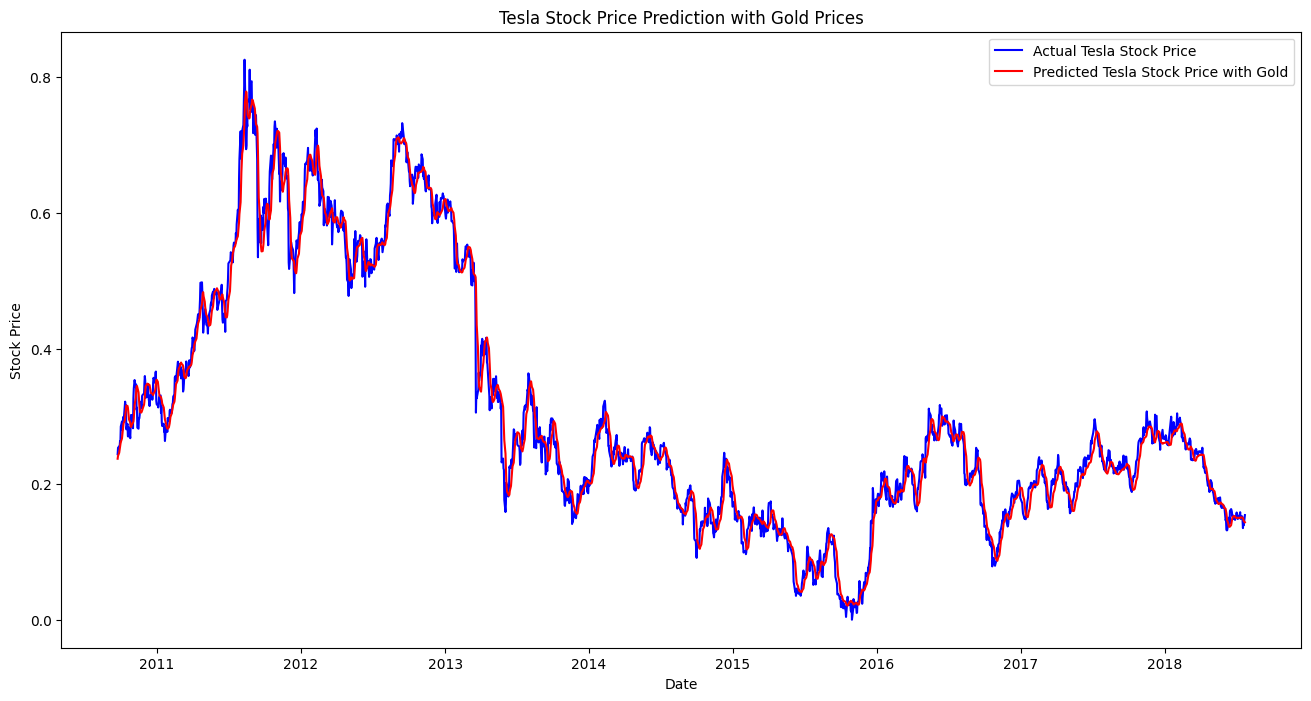

In [13]:
plt.figure(figsize=(16, 8))
plt.plot(tesla_data.index[seq_length:train_size + seq_length:], Y_train[:, 1], color='blue',
         label='Actual Tesla Stock Price')
plt.plot(tesla_data.index[seq_length:train_size + seq_length:], train_predict[:, 1], color='red',
         label='Predicted Tesla Stock Price with Gold')
plt.title('Tesla Stock Price Prediction with Gold Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# PART II

### Some imports

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import metrics

## Data Preperation

In [15]:
tesla_df = pd.read_csv("./docs/Homework3 - TSLA.csv")
tesla_data = tesla_df
tesla_data['Date'] = pd.to_datetime(tesla_data['Date'])
tesla_data.set_index('Date', inplace=True)
tesla_data.sort_index(inplace=True)
tesla_data = tesla_data[:2950]

train_size = int(len(tesla_data) * 0.7)
train_data = tesla_data[:train_size]
test_data = tesla_data[train_size:]

train_data = train_data["Close"].tolist()
test_data = test_data["Close"].tolist()

### Create sequence

In [16]:
def to_sequences(obs, sequence_size):
    x = []
    y = []

    for i in range(len(obs) - sequence_size):
        #print(i)
        window = obs[i:(i + sequence_size)]
        after_window = obs[i + sequence_size]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)

    return np.array(x), np.array(y)


seq_length = 20  #  for better performance
x_train, y_train = to_sequences(train_data, seq_length)
x_test, y_test = to_sequences(test_data, seq_length)

print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

Shape of training set: (2045, 20, 1)
Shape of test set: (865, 20, 1)


### The Encoder: Normalization, Attention & Feed Forward

In [17]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

### The Model with Transformer

In [18]:
def build_model(
        input_shape,
        head_size,
        num_heads,
        ff_dim,
        num_transformer_blocks,
        mlp_units,
        dropout=0,
        mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)  # Pooling
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

## Go for Model Compile

In [19]:
input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(learning_rate=1e-4))
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=64,
    callbacks=callbacks,
)

Epoch 1/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 1377.1561 - val_loss: 1939.3920
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 531.3652 - val_loss: 437.0489
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 254.2700 - val_loss: 68.4229
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 202.2214 - val_loss: 29.0220
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 191.5980 - val_loss: 28.5005


In [20]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 20, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 20, 1)     │          2 │ input_layer_2[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 1)     │      7,169 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 20, 1)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 20, 1)     │          0 │ dropout_1[0][0],  │
│                     │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 1)     │          2 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 20, 4)     │          8 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 20, 4)     │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 20, 1)     │          5 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 20, 1)     │          0 │ conv1d_1[0][0],   │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 1)     │          2 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 1)     │      7,169 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 20, 1)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 20, 1)     │          0 │ dropout_4[0][0],  │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 1)     │          2 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 20, 4)     │          8 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 20, 4)     │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 20, 1)     │          5 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 20, 1)     │          0 │ conv1d_3[0][0],   │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 94,685 (369.87 KB)

 Trainable params: 31,561 (123.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,124 (246.58 KB)

### Predictions

In [21]:
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("RMSE: {}".format(score))

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
RMSE: 60.105465744908884


### Plot the results

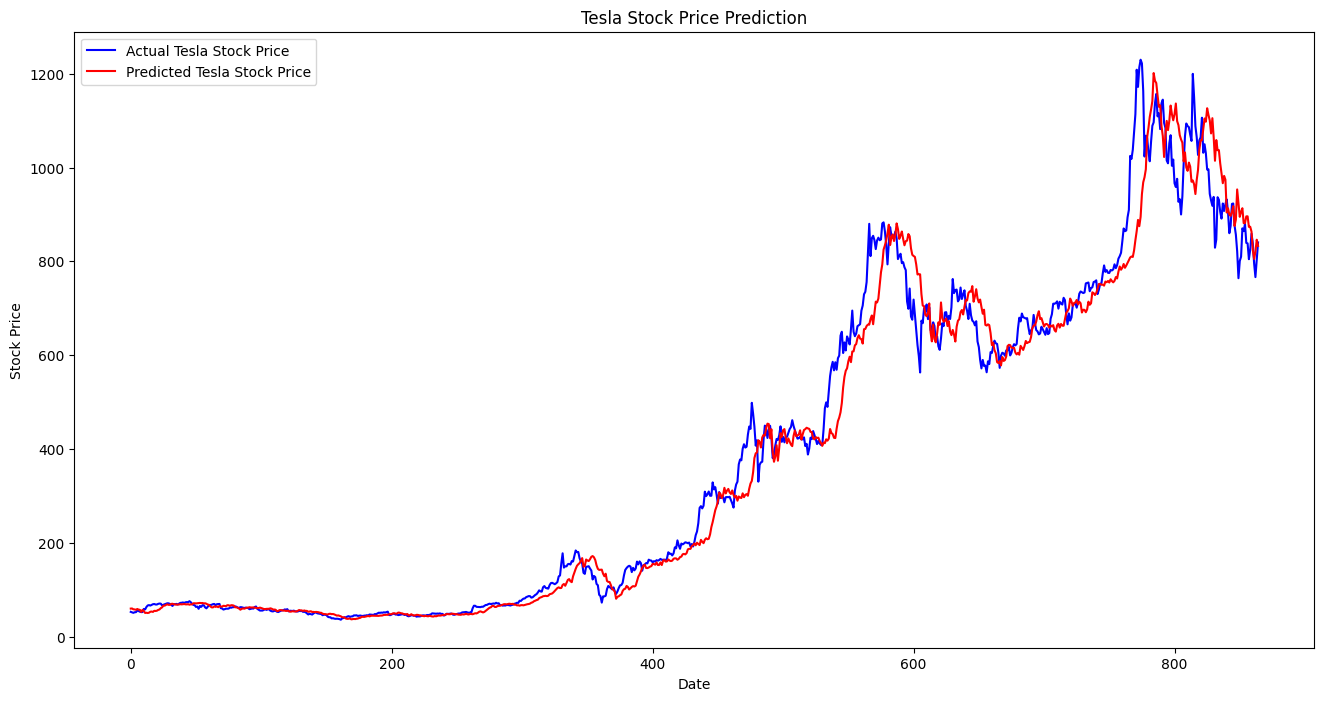

In [22]:
plt.figure(figsize=(16, 8))
plt.plot(y_test, color='blue', label='Actual Tesla Stock Price')
plt.plot(pred, color='red', label='Predicted Tesla Stock Price')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### Repeat the above using an additional feature. Go for Data Preperation

In [23]:
gold_data = pd.read_csv('./docs/gold.csv')
gold_data.sort_values('Date', inplace=True)
gold_data['Date'] = pd.to_datetime(gold_data['Date'])

combined = pd.merge(tesla_data, gold_data, on='Date', how='inner')
combined_data = np.array(combined[['Close_x', 'Close_y']])
# combined_data = combined[['Close_x', 'Close_y']]

### Create sequence with gold data's

In [24]:
def create_dataset_with_gold(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), :]  # Use 'Close' and 'Gold' prices
        X.append(a)
        Y.append(dataset[i + time_step, :])  # Predict both 'Close_x' and 'Close_y'
    return np.array(X), np.array(Y)

In [25]:
X, Y = create_dataset_with_gold(combined_data, seq_length)

print("Shape of training set: {}".format(X.shape))
print("Shape of test set: {}".format(Y.shape))

Shape of training set: (2857, 20, 2)
Shape of test set: (2857, 2)


In [26]:
train_size = int(len(X) * 0.7)  # (70% train, 30% test)
x_train, x_test = X[:train_size], X[train_size:]
y_train, y_test = Y[:train_size], Y[train_size:]

print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

Shape of training set: (1999, 20, 2)
Shape of test set: (858, 20, 2)


### The Encoder With Gold: Normalization, Attention & Feed Forward

In [27]:
def transformer_encoder_with_gold(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

### The Model With Transformer & Gold Feature

In [28]:
def build_model_with_gold(
        input_shape,
        head_size,
        num_heads,
        ff_dim,
        num_transformer_blocks,
        mlp_units,
        dropout=0,
        mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder_with_gold(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D()(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    # I Added dense layer for new gold feature, 
    # so output give us two dense like Close_x from tesla data and Close_y from gold data, like part I
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(2)(x)
    return keras.Model(inputs, outputs)

## Go for Model Compile

In [29]:
input_shape = x_train.shape[1:]

model_with_gold = build_model_with_gold(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model_with_gold.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(learning_rate=1e-4))
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

model_with_gold.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=64,
    callbacks=callbacks,
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - loss: 1195253.7500 - val_loss: 807003.4375
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 903915.3750 - val_loss: 603517.3125
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 673717.0625 - val_loss: 419713.5625
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 469789.5938 - val_loss: 261924.8594
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 307746.3125 - val_loss: 136127.5156
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 189727.3125 - val_loss: 58071.0742
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 117251.3281 - val_loss: 20098.8145
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 80943.0859 - val_loss: 6161.7612
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 69634.6094 - val_loss: 2381.9177
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 69153.3984 - val_loss: 1191.4834


In [30]:
model_with_gold.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 20, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 2)     │          4 │ input_layer_3[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 2)     │     11,266 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 20, 2)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 20, 2)     │          0 │ dropout_14[0][0], │
│                     │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 2)     │          4 │ add_8[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 20, 4)     │         12 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 20, 4)     │          0 │ conv1d_8[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 20, 2)     │         10 │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 20, 2)     │          0 │ conv1d_9[0][0],   │
│                     │                   │            │ add_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 2)     │          4 │ add_9[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 2)     │     11,266 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 20, 2)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 20, 2)     │          0 │ dropout_17[0][0], │
│                     │                   │            │ add_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 2)     │          4 │ add_10[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 20, 4)     │         12 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 20, 4)     │          0 │ conv1d_10[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 20, 2)     │         10 │ dropout_18[0][0]

 Total params: 187,016 (730.54 KB)

 Trainable params: 62,338 (243.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 124,678 (487.03 KB)

### Predictions

In [31]:
pred = model_with_gold.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(y_test, pred))
print("Score (RMSE): {}".format(score))

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Score (RMSE): 334.04390150261986


# Plot the results

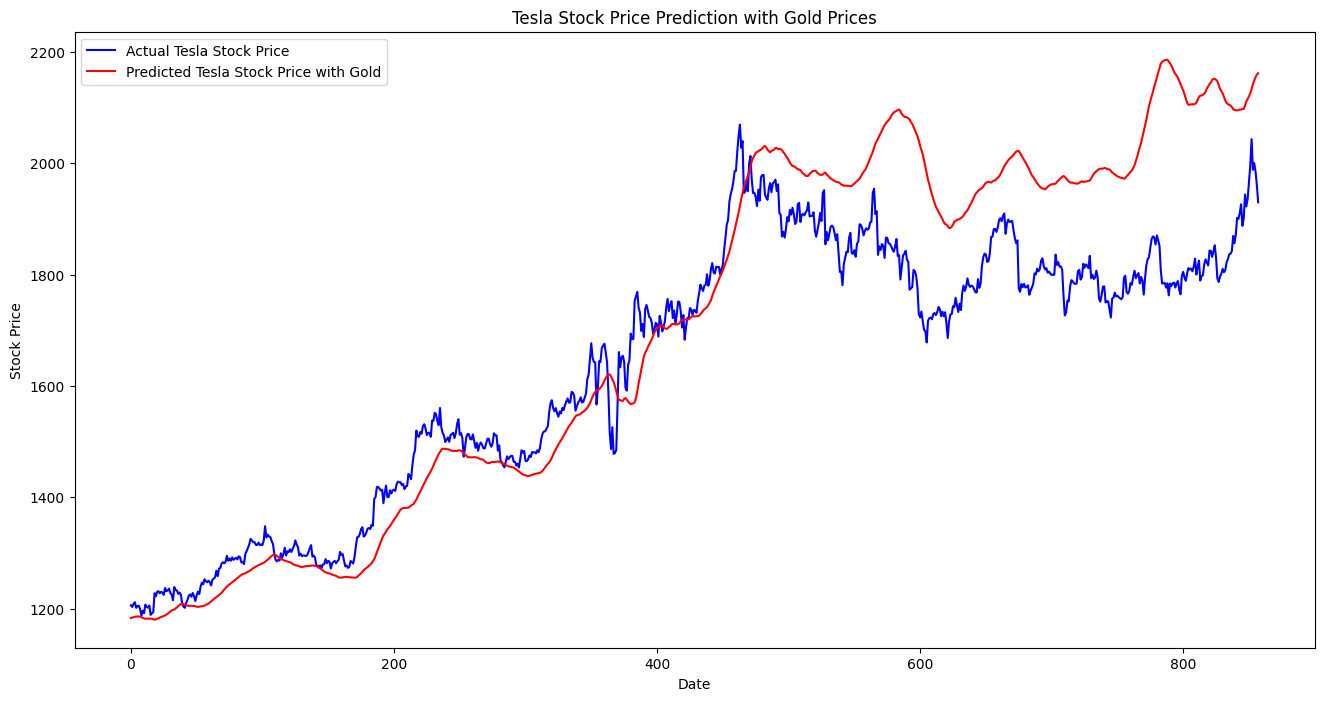

In [32]:
plt.figure(figsize=(16, 8))
plt.plot(y_test[:, 1], color='blue', label='Actual Tesla Stock Price')
plt.plot(pred[:, 1], color='red', label='Predicted Tesla Stock Price with Gold')
plt.title('Tesla Stock Price Prediction with Gold Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()